<a href="https://colab.research.google.com/github/toful/Shazam/blob/master/src/Shazam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [228]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.io import wavfile
import numpy as np
from skimage.feature import peak_local_max
import hashlib
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import dataset

In [229]:
class Fingerprint:
    def __init__(self):
        #default values
        self.NFFT = 4096
        self.noverlap = int(self.NFFT * 0.5)
        #Getting the coords of the local max peaks
        self.min_distance = 20
        self.threshold_abs = 0.0   #Minimum intensity of peaks. By default, the minimum intensity of the image.
        self.threshold_rel = 0.0   #Minimum intensity of peaks, calculated as: max(image) * threshold_rel.
        self.num_peaks = 1200
        #Number of links for each node
        self.num_links = 3
        
    def fingerprint_file(self, audio_file):
        sample_rate, samples = self.sample_audio( audio_file )
        spectrum, freqs, t = self.generate_spectogram(samples, sample_rate)
        coord = self.get_local_maxima(spectrum, freqs, t, samples, sample_rate)
        song_hashes = self.generate_hashes(coord)
        return song_hashes
        
    def sample_audio(self, audio_file):
        sample_rate, samples = wavfile.read( audio_file )
        if len( samples[0] ) > 1:
          return sample_rate, samples[:, 0]
    
    def generate_spectogram(self, samples, sample_rate):
        plt.suptitle("Sepectogram of the song")
        plt.xlabel( "Time (s)" )
        plt.ylabel( "Frequency")
        spectrum, freqs, t, spectrum_plot = plt.specgram(
            samples,
            NFFT=self.NFFT, 
            Fs=sample_rate, 
            detrend = mlab.detrend_none,
            window = mlab.window_hanning,
            noverlap = self.noverlap )
        plt.show() 
        return spectrum, freqs, t
        
    def get_local_maxima(self, spectrum, freqs, t, samples, sample_rate):
        coord = peak_local_max( spectrum, 
                                min_distance = self.min_distance,
                                threshold_abs = self.threshold_abs,
                                threshold_rel = self.threshold_rel,
                                num_peaks = self.num_peaks)
        coord_aux = np.column_stack( ( np.take( freqs, coord[:, 0]), np.take( t, coord[:, 1]) ) )

        #Printing the spectogram with the peaks
        plt.suptitle("Sepectogram of the song with local maxima")
        plt.xlabel( "Time (s)" )
        plt.ylabel( "Frequency")
        plt.plot(coord_aux[:, 1], coord_aux[:, 0], 'r.')
        plt.specgram( samples, NFFT=self.NFFT, Fs=sample_rate, detrend = mlab.detrend_none, window = mlab.window_hanning, noverlap = self.noverlap )
        plt.show()
        return coord_aux
        
    def generate_hashes(self, coord_aux):
        #Sort the list of [freqs , time] using the time
        coord_aux = coord_aux[ coord_aux[:,1].argsort() ]

        song_hashes = []
        for i in range( 0, len(coord_aux) - self.num_links ):
          for j in range( i+1, i+self.num_links ):
            aux = str( int(coord_aux[i, 0]) ) + str( int(coord_aux[j, 0]) ) + str( int(coord_aux[j, 1] - coord_aux[i, 1]) )
            song_hashes += [ [hashlib.md5( aux.encode('utf-8') ).hexdigest(), coord_aux[i,1]] ]
        return song_hashes

In [230]:
class Database:
    def __init__(self):
        self.db = dataset.connect('sqlite:///songs.db')
        self.songs = self.db['songs']
        self.song_names = self.db['song_names']
    
    def insert_song(self, song_name, song_hashes):
        song_id = hashlib.md5( song_name.encode('utf-8') ).hexdigest()
        hashes = []
        for hash in song_hashes:
            hashes.append(dict(song_id=song_id, hash=hash[0], offset=hash[1]))
        self.songs.insert_many(hashes)
        self.song_names.insert(dict(song_id=song_id, song_name=song_name))
        
    def get_matching_songs(self, hashes):
        coincidences = {}
        points = {}
        for hash in hashes:
            songs = self.songs.find(hash=hash[0])
            for song in songs:
                coincidences.setdefault(song['song_id'], []).append(hash[1] - song['offset'])
                points.setdefault(song['song_id'], []).append([hash[1], song['offset']])
        return coincidences, points
    
    def get_song_name(self, song_id):
        name = self.song_names.find_one(song_id=song_id)
        if name is not None:
            return name['song_name']
        else:
            return "Name not in Database"

In [231]:
class Compare:
    def __init__(self, database):
        self.db = database
    
    def compare_songs2(self, song_hashes):
        coincidences, points = self.db.get_matching_songs(song_hashes)
        if len(coincidences.keys()) > 0:
            for song in coincidences.keys():
                print("Coincidences found with song", self.db.get_song_name(song))
                p = np.array( points[song] ) 
                plt.suptitle("Matches between two songs")
                plt.xlabel( "Original Song Time (s)" )
                plt.ylabel( "Predicting Song Time (s)")
                plt.plot( p[:, 0], p[:, 1], 'r.')

                plt.show()
                
                plt.hist(x=coincidences[song], bins='auto')
                plt.xlabel('Offset (s)')
                plt.ylabel('Frequency')
                plt.title('Offset histogram')
                
                plt.show()
        else:
            print("No matches found!")
            
    def compare_songs(self, song_hashes):
        coincidences, points = self.db.get_matching_songs(song_hashes)
        result = []
        if len( coincidences.keys() ) > 0:
            for song in coincidences.keys():
                (n, bins, patches) = plt.hist(x=coincidences[song], bins=20)
                #coincidence_value = np.max( n )/np.sum( n )
                coincidence_value = np.max( n )
                result += [ [ coincidence_value, self.db.get_song_name(song) ] ]
            result.sort(key=lambda x: -x[0])
        else:
            print("No matches found!")
        return result

<ipython-input-229-8f646491b3b5>:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, samples = wavfile.read( audio_file )


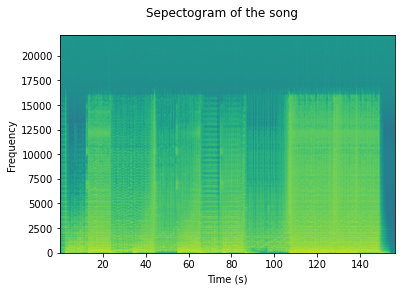

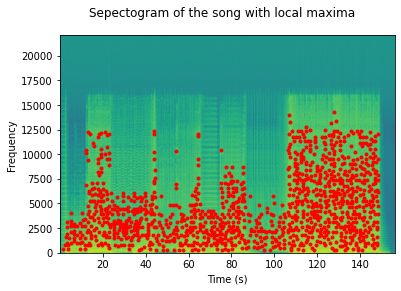

In [232]:
f = Fingerprint()
song_hashes = f.fingerprint_file('06. Over the Horizon.wav')

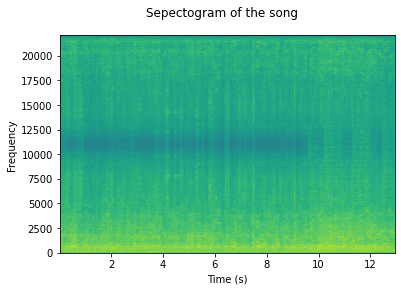

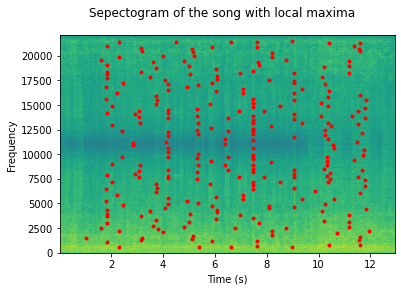

In [233]:
song2_hashes = f.fingerprint_file('12_I_Wanna_be_a_Machine_1.wav')

In [234]:
db = Database()
#db.insert_song('01. Bourgade', song_hashes)

[[12.0, '12. I_Wanna_be_a_Machine'],
 [6.0, '25. Cosmic_Relevance'],
 [6.0, '09. In your heart'],
 [6.0, '33. Shanghaied'],
 [6.0, '38. Never_Really_Change'],
 [6.0, '16. Downfall'],
 [6.0, '18. Dog_Soldier_Stand_Down'],
 [6.0, '13. The_Debt'],
 [6.0, '39. Night_Owl'],
 [6.0, '15. Homeroad']]

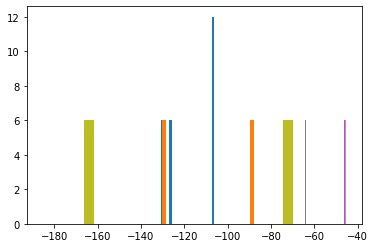

In [235]:
c = Compare(db)
c.compare_songs(song2_hashes)